In [1]:
import pandas as pd

df = pd.read_csv('input/all_images.csv')
df['file_name']=df['image_id']+'.jpg'
df=df[['file_name','dx','lesion_id']]
#df.head()

from sklearn.model_selection import train_test_split
label_dataframe=df.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(df, label_dataframe, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.4, random_state=42)
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(65, 2)
(97, 2)
(18, 2)


In [2]:
train=pd.concat([X_train,y_train],axis=1)
train.head()
val=pd.concat([X_val,y_val],axis=1)
val.head()
test=pd.concat([X_test,y_test],axis=1)
test.head()

,file_name,lesion_id,dx
19,0 (21).jpg,9,fungal_infection
42,0 (44).jpg,21,fungal_infection
153,0 (154).jpg,62,acne
78,0 (80).jpg,34,papule
145,0 (146).jpg,59,fungal_infection


In [3]:
from sklearn import preprocessing
vle = preprocessing.LabelEncoder()
vle.fit(val['dx'])
label=vle.transform(val['dx']) 
print(list(vle.classes_))
val['label']=label
print(train.head())
le_name_mapping = dict(zip(vle.classes_, vle.transform(vle.classes_)))
print(le_name_mapping)

trle = preprocessing.LabelEncoder()
trle.fit(train['dx'])
label=trle.transform(train['dx']) 
print(list(trle.classes_))
train['label']=label
print(train.head())
le_name_mapping = dict(zip(trle.classes_, trle.transform(trle.classes_)))
print(le_name_mapping)

le = preprocessing.LabelEncoder()
le.fit(test['dx'])
label=le.transform(test['dx']) 
print(list(le.classes_))
test['label']=label
print(test.head())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
       file_name  lesion_id                dx
44    0 (46).jpg         22            papule
148  0 (149).jpg         59  fungal_infection
141  0 (142).jpg         57              acne
83    0 (85).jpg         36  fungal_infection
96    0 (98).jpg         40  fungal_infection
{'acne': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'mole': 6, 'papule': 7, 'scabies': 8, 'skin_virus': 9}
['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
       file_name  lesion_id                dx  label
44    0 (46).jpg         22            papule      7
148  0 (149).jpg         59  fungal_infection      3
141  0 (142).jpg         57              acne      0
83    0 (85).jpg         36  fungal_infection  

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
rescale = 1./255,
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.4, # Randomly zoom image 
shear_range=0.2,
width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=True)  # randomly flip images)


In [6]:
train_data= train_generator.flow_from_dataframe(
dataframe=train,
x_col="file_name",
y_col="dx",
batch_size=4,
seed=311,
directory="input/test",
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 97 validated image filenames belonging to 10 classes.


In [7]:
test_generator=ImageDataGenerator(
rescale = 1./255)
test_data= test_generator.flow_from_dataframe(
dataframe=test,
x_col="file_name",
y_col="dx",
seed=311,
directory="input/test",
shuffle=False,
batch_size=1,
class_mode=None,
target_size=(224,224))

Found 18 validated image filenames.


In [8]:
val_data=test_generator.flow_from_dataframe(
dataframe=val,
directory="input/test",
x_col="file_name",
y_col="dx",
batch_size=1,
seed=311,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 65 validated image filenames belonging to 10 classes.


In [9]:
print(train['dx'].value_counts())
print(val['dx'].value_counts())
print(test['dx'].value_counts())

fungal_infection       27
acne                   13
dermatitis             12
bacterial_infection    12
papule                 11
skin_virus              6
hypertrophy             5
scabies                 5
mole                    4
hyperpigmentation       2
Name: dx, dtype: int64
fungal_infection       18
dermatitis             11
papule                 10
acne                    8
mole                    6
bacterial_infection     6
hyperpigmentation       3
hypertrophy             1
skin_virus              1
scabies                 1
Name: dx, dtype: int64
fungal_infection    7
dermatitis          3
papule              3
mole                2
acne                2
skin_virus          1
Name: dx, dtype: int64


In [10]:
from sklearn.utils import class_weight
import numpy as np

class_weight = np.round(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train['dx']))
print(class_weight)
print(train_data.class_indices)
print(val_data.class_indices)
print(train['dx'].value_counts())

[1. 1. 1. 0. 5. 2. 2. 1. 2. 2.]
{'acne': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'mole': 6, 'papule': 7, 'scabies': 8, 'skin_virus': 9}
{'acne': 0, 'bacterial_infection': 1, 'dermatitis': 2, 'fungal_infection': 3, 'hyperpigmentation': 4, 'hypertrophy': 5, 'mole': 6, 'papule': 7, 'scabies': 8, 'skin_virus': 9}
fungal_infection       27
acne                   13
dermatitis             12
bacterial_infection    12
papule                 11
skin_virus              6
hypertrophy             5
scabies                 5
mole                    4
hyperpigmentation       2
Name: dx, dtype: int64


In [11]:
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                    patience=8, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import AUC

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='kullback_leibler_divergence',
              optimizer='rmsprop',
              metrics=['top_k_categorical_accuracy', 'categorical_accuracy'])

Using TensorFlow backend.


In [ ]:
model.summary()

In [12]:
history=model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=100,
                            class_weight=class_weight,
                            callbacks=[learning_rate_reduction])

k_categorical_accuracy: 0.9462 - categorical_accuracy: 0.1183 - val_loss: -1.4506e-05 - val_top_k_categorical_accuracy: 1.0000 - val_categorical_accuracy: 0.1231
Epoch 23/100
24/24 [==============================] - 9s 391ms/step - loss: 0.1288 - top_k_categorical_accuracy: 0.5914 - categorical_accuracy: 0.1290 - val_loss: -1.4506e-05 - val_top_k_categorical_accuracy: 0.7538 - val_categorical_accuracy: 0.1385
Epoch 24/100
24/24 [==============================] - 9s 368ms/step - loss: 0.1025 - top_k_categorical_accuracy: 0.6000 - categorical_accuracy: 0.0889 - val_loss: -1.4387e-05 - val_top_k_categorical_accuracy: 0.9538 - val_categorical_accuracy: 0.1231
Epoch 25/100
24/24 [==============================] - 9s 377ms/step - loss: 0.0621 - top_k_categorical_accuracy: 0.6562 - categorical_accuracy: 0.1146 - val_loss: -1.4506e-05 - val_top_k_categorical_accuracy: 0.9538 - val_categorical_accuracy: 0.1385
Epoch 26/100
24/24 [==============================] - 9s 372ms/step - loss: 0.0400 - 

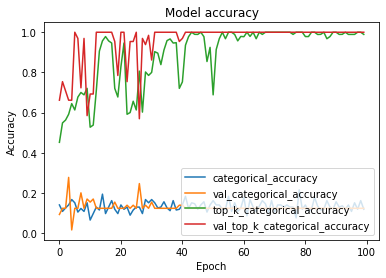

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['categorical_accuracy', 'val_categorical_accuracy', 'top_k_categorical_accuracy', 'val_top_k_categorical_accuracy'], loc='lower right')
plt.show()

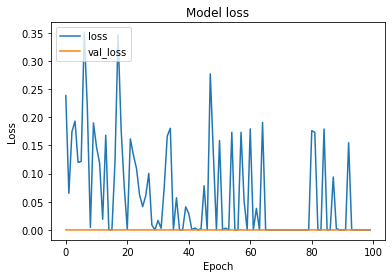

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [15]:
val_data.reset()
predictions = model.predict_generator(val_data, steps=val_data.samples/val_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)
print(y_pred)
ground_truth=val_data.classes

65/65 [==============================] - 6s 88ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['acne', 'bacterial_infection', 'dermatitis', 'fungal_infection', 'hyperpigmentation', 'hypertrophy', 'mole', 'papule', 'scabies', 'skin_virus']
print(classification_report(val_data.classes, y_pred, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

               acne       0.12      1.00      0.22         8
bacterial_infection       0.00      0.00      0.00         6
         dermatitis       0.00      0.00      0.00        11
   fungal_infection       0.00      0.00      0.00        18
  hyperpigmentation       0.00      0.00      0.00         3
        hypertrophy       0.00      0.00      0.00         1
               mole       0.00      0.00      0.00         6
             papule       0.00      0.00      0.00        10
            scabies       0.00      0.00      0.00         1
         skin_virus       0.00      0.00      0.00         1

           accuracy                           0.12        65
          macro avg       0.01      0.10      0.02        65
       weighted avg       0.02      0.12      0.03        65



In [17]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

18/18 [==============================] - 2s 89ms/step


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

18/18 [==============================] - 1s 80ms/step


In [19]:
ground_truth=test['label']
print('Confusion Matrix')
print(confusion_matrix(ground_truth, y_pred))

Confusion Matrix
[[2 0 0 0 0 0]
 [3 0 0 0 0 0]
 [7 0 0 0 0 0]
 [2 0 0 0 0 0]
 [3 0 0 0 0 0]
 [1 0 0 0 0 0]]
